In [57]:
import os
import xml.etree.ElementTree as ET
from datetime import datetime
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
from matplotlib import pyplot as plt
import pywt
import time

In [58]:
def read_xml_files(root_dir):

    def get_parking(parking_label):
        parking_helper = {'pucpr': 0, 'ufpr04': 1, 'ufpr05': 2}
        return parking_helper[parking_label]

    def get_weather(weather_label):
        weather_helper = {'Cloudy': 0, 'Rainy': 1, 'Sunny': 2}
        return weather_helper[weather_label]

    data = []

    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.xml'):
                xml_path = os.path.join(subdir, file)
                print(f"Reading data from {xml_path}")
                try:
                    tree = ET.parse(xml_path)
                    root = tree.getroot()

                    parking_id = get_parking(root.attrib.get('id'))
                    occupied_spaces = 0
                    all_spaces = 0
                    for space in root.findall('.//space'):
                        if isinstance(space.get('occupied'), str):
                            occupied = space.get('occupied')
                            occupied_spaces += int(occupied)
                            all_spaces += 1

                    weather = get_weather(xml_path.split('\\')[-3])
                    date = xml_path.split('\\')[-1].split('.')[0]
                    # from January (0) to December (12)
                    month = int(date.split('-')[1])
                    # from Monday (0) to Sunday (7)
                    weekday = datetime.strptime(xml_path.split('\\')[-2], '%Y-%m-%d').weekday()
                    weekend = 1 if weekday == 6 or weekday == 7 else 0
                    # number of seconds after midnight
                    temp_time = date.split('_')[1:]
                    time = int(temp_time[0]) * 3600 + int(temp_time[1]) * 60 + int(temp_time[2])

                    data_sample = {
                        'parking_id': parking_id,
                        'occupied': occupied_spaces / all_spaces,
                        'weather': weather,
                        'month': month,
                        'weekday': weekday,
                        'weekend': weekend,
                        'time': time
                    }
                    data.append(data_sample)
                except ET.ParseError as e:
                    print(f"Error parsing {xml_path}: {e}")
    print(f"Reading data from {root_dir} done!")
    df = pd.DataFrame(data, columns=[
        'parking_id',  
        'occupied',
        'weather',
        'month', 
        'weekday',
        'weekend', 
        'time'
    ])
    return df


In [59]:
root_directory = 'C:\\University\\ML\\coursework\\PKLot\\PKLot\\PKLot'
df = read_xml_files(root_directory)
df.to_csv('data.csv', index=False)

Reading data from C:\University\ML\coursework\PKLot\PKLot\PKLot\PUCPR\Cloudy\2012-09-12\2012-09-12_06_05_16.xml
Reading data from C:\University\ML\coursework\PKLot\PKLot\PKLot\PUCPR\Cloudy\2012-09-12\2012-09-12_06_10_30.xml
Reading data from C:\University\ML\coursework\PKLot\PKLot\PKLot\PUCPR\Cloudy\2012-09-12\2012-09-12_06_15_44.xml
Reading data from C:\University\ML\coursework\PKLot\PKLot\PKLot\PUCPR\Cloudy\2012-09-12\2012-09-12_06_20_57.xml
Reading data from C:\University\ML\coursework\PKLot\PKLot\PKLot\PUCPR\Cloudy\2012-09-12\2012-09-12_06_26_11.xml
Reading data from C:\University\ML\coursework\PKLot\PKLot\PKLot\PUCPR\Cloudy\2012-09-12\2012-09-12_06_31_24.xml
Reading data from C:\University\ML\coursework\PKLot\PKLot\PKLot\PUCPR\Cloudy\2012-09-12\2012-09-12_06_36_36.xml
Reading data from C:\University\ML\coursework\PKLot\PKLot\PKLot\PUCPR\Cloudy\2012-09-12\2012-09-12_06_41_49.xml
Reading data from C:\University\ML\coursework\PKLot\PKLot\PKLot\PUCPR\Cloudy\2012-09-12\2012-09-12_06_47

In [96]:
df = pd.read_csv('data.csv')
normalized_df = pd.read_csv('data.csv')
denoised_df = pd.read_csv('data.csv')

In [97]:
df['weekday'].unique()

array([2, 6, 4, 5, 3, 1, 0], dtype=int64)

In [98]:
df['month'].unique()

array([ 9, 10, 11, 12,  1,  2,  3,  4], dtype=int64)

In [99]:
print(f"Час від {df['time'].min() / 3600} до {df['time'].max() / 3600}")

Час від 5.427222222222222 до 21.255


In [100]:
df = df.astype('float64')
normalized_df = normalized_df.astype('float64')
denoised_df = denoised_df.astype('float64')

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12416 entries, 0 to 12415
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   parking_id  12416 non-null  float64
 1   occupied    12416 non-null  float64
 2   weather     12416 non-null  float64
 3   month       12416 non-null  float64
 4   weekday     12416 non-null  float64
 5   weekend     12416 non-null  float64
 6   time        12416 non-null  float64
dtypes: float64(7)
memory usage: 679.1 KB


In [102]:
df.head()

,parking_id,occupied,weather,month,weekday,weekend,time
0,0.0,0.00,0.0,9.0,2.0,0.0,21916.0
1,0.0,0.00,0.0,9.0,2.0,0.0,22230.0
2,0.0,0.00,0.0,9.0,2.0,0.0,22544.0
3,0.0,0.01,0.0,9.0,2.0,0.0,22857.0
4,0.0,0.00,0.0,9.0,2.0,0.0,23171.0


In [103]:
df.describe()

,parking_id,occupied,weather,month,weekday,weekend,time
count,12416.000000,12416.000000,12416.000000,12416.000000,12416.00000,12416.000000,12416.000000
mean,0.974146,0.504799,1.221488,7.145377,3.20385,0.153592,47302.294781
std,0.833100,0.415038,0.918109,4.121714,1.95736,0.360572,13495.047366
min,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,19538.000000
25%,0.000000,0.025000,0.000000,3.000000,1.00000,0.000000,36203.250000
50%,1.000000,0.600000,2.000000,9.000000,3.00000,0.000000,47426.000000
75%,2.000000,0.940000,2.000000,11.000000,5.00000,0.000000,58511.000000
max,2.000000,1.000000,2.000000,12.000000,6.00000,1.000000,76518.000000


In [104]:
scaler = MinMaxScaler()
weather_scaled = scaler.fit_transform(normalized_df['weather'].values.reshape(-1, 1))
weekday_scaled = scaler.fit_transform(normalized_df['weekday'].values.reshape(-1, 1))
type_scaled = scaler.fit_transform(normalized_df['parking_id'].values.reshape(-1, 1))
month_scaled = scaler.fit_transform(normalized_df['month'].values.reshape(-1, 1))

normalized_df['weather'] = weather_scaled
normalized_df['weekday'] = weekday_scaled
normalized_df['parking_id'] = type_scaled
normalized_df['month'] = month_scaled
normalized_df['time'] = df['time'] / 86400

In [105]:
normalized_df.describe()

,parking_id,occupied,weather,month,weekday,weekend,time
count,12416.000000,12416.000000,12416.000000,12416.000000,12416.000000,12416.000000,12416.000000
mean,0.487073,0.504799,0.610744,0.558671,0.533975,0.153592,0.547480
std,0.416550,0.415038,0.459055,0.374701,0.326227,0.360572,0.156193
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.226134
25%,0.000000,0.025000,0.000000,0.181818,0.166667,0.000000,0.419019
50%,0.500000,0.600000,1.000000,0.727273,0.500000,0.000000,0.548912
75%,1.000000,0.940000,1.000000,0.909091,0.833333,0.000000,0.677211
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.885625


In [106]:
normalized_df.head()

,parking_id,occupied,weather,month,weekday,weekend,time
0,0.0,0.00,0.0,0.727273,0.333333,0.0,0.253657
1,0.0,0.00,0.0,0.727273,0.333333,0.0,0.257292
2,0.0,0.00,0.0,0.727273,0.333333,0.0,0.260926
3,0.0,0.01,0.0,0.727273,0.333333,0.0,0.264549
4,0.0,0.00,0.0,0.727273,0.333333,0.0,0.268183


In [107]:
def dwt_denoise(data, wavelet='bior4.4', level=1):
    coeffs = pywt.wavedec(data, wavelet, level=level)
    threshold = 0.1 * max(coeffs[0])
    coeffs = [pywt.threshold(c, threshold, mode='hard') for c in coeffs]
    denoised_data = pywt.waverec(coeffs, wavelet)
    return denoised_data

def dwt_denoise_dataframe(df, wavelet='bior4.4', level=8):
    denoised_df = pd.DataFrame()
    for col in df.columns:
        if col != 'occupied':
            denoised_df[col] = dwt_denoise(df[col], wavelet, level)
        else:
            denoised_df[col] = df[col]
    return denoised_df

denoised_df = dwt_denoise_dataframe(normalized_df)

In [108]:
denoised_df.describe()

,parking_id,occupied,weather,month,weekday,weekend,time
count,12416.000000,12416.000000,12416.000000,12416.000000,12416.000000,12416.000000,12416.000000
mean,0.486083,0.504799,0.610005,0.555118,0.533699,0.155215,0.547204
std,0.417018,0.415038,0.456086,0.375103,0.298896,0.339633,0.101512
min,-0.069647,0.000000,-0.117261,-0.194819,-0.150573,-0.280810,0.241074
25%,0.000000,0.025000,0.003421,0.182522,0.298376,-0.013253,0.481005
50%,0.500000,0.600000,0.983678,0.728561,0.540216,0.006305,0.547549
75%,1.000000,0.940000,1.000000,0.864907,0.782202,0.093335,0.621711
max,1.030651,1.000000,1.136236,1.094995,1.137018,1.192520,0.934530


In [109]:
denoised_df.head()

,parking_id,occupied,weather,month,weekday,weekend,time
0,0.0,0.00,0.0,0.759834,0.330717,0.150274,0.307684
1,0.0,0.00,0.0,0.759933,0.332607,0.154524,0.308250
2,0.0,0.00,0.0,0.760028,0.334744,0.157599,0.308835
3,0.0,0.01,0.0,0.760119,0.337151,0.159334,0.309442
4,0.0,0.00,0.0,0.760203,0.339970,0.158597,0.310080


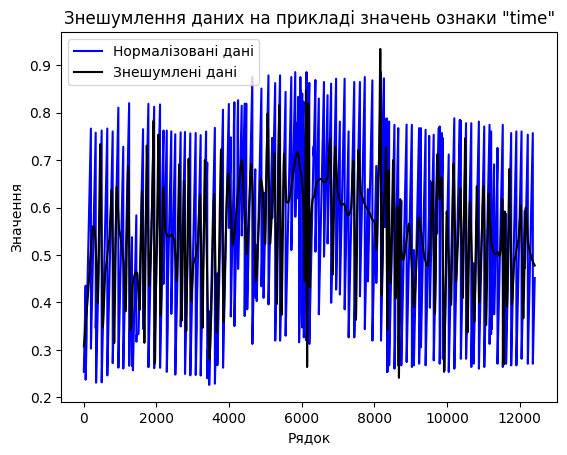

In [110]:
plt.plot(normalized_df['time'], 'blue', label='Нормалізовані дані')
plt.plot(denoised_df['time'], 'black', label='Знешумлені дані')
plt.xlabel('Рядок')
plt.ylabel('Значення')
plt.title('Знешумлення даних на прикладі значень ознаки "time"')
plt.legend()
plt.show()

### DNN

In [111]:
class DenseNeuralNetwork(torch.nn.Module):
    def __init__(self, n_features, n_layers, n_hidden, l1_lambda=0.00001):
        super().__init__()
        layers = [torch.nn.Linear(n_features, n_hidden, bias=True), 
                  torch.nn.BatchNorm1d(n_hidden), 
                  torch.nn.ReLU(), 
                  ]
        for _ in range(n_layers - 1):
            layers += [torch.nn.Linear(n_hidden, n_hidden, bias=True), 
                       torch.nn.BatchNorm1d(n_hidden), 
                       torch.nn.ReLU(),
                       ]
        layers += [torch.nn.Linear(n_hidden, 1, bias=True), torch.nn.Sigmoid()]
        self.linear_relu_stack = torch.nn.Sequential(*layers)
        self.l1_lambda = l1_lambda

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
    
    def l1_regularization_loss(self):
        l1_loss = 0
        for param in self.parameters():
            l1_loss += torch.norm(param, p=1)
        return l1_loss

In [112]:
def train_one_epoch(dataloader, model, loss_fn, optimizer, device):
    summary_loss = 0.0
    targets, predictions = [], []
    
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y) + model.l1_lambda * model.l1_regularization_loss()
        loss.backward()
        optimizer.step()
        # FOR R2 SCORE AND MAE
        targets.extend(y.detach().cpu().numpy())
        predictions.extend(pred.detach().cpu().numpy())
        # FOR LOSS
        summary_loss += loss.item()
    
    r2 = r2_score(targets, predictions)
    mae = mean_absolute_error(targets, predictions)
    rmse = root_mean_squared_error(targets, predictions)
    avg_loss = summary_loss / (batch + 1)
    return {'r2_score': r2, 'mae': mae, 'rmse': rmse, 'loss': avg_loss}

In [113]:
def test_one_epoch(dataloader, model, loss_fn, device):
    summary_loss = 0.0
    targets, predictions = [], []
    
    model.eval()
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y) + model.l1_lambda * model.l1_regularization_loss()
            # FOR R2 SCORE AND MAE
            targets.extend(y.cpu().numpy())
            predictions.extend(pred.cpu().numpy())
            # FOR LOSS
            summary_loss += loss.item()

    r2 = r2_score(targets, predictions)
    mae = mean_absolute_error(targets, predictions)
    rmse = root_mean_squared_error(targets, predictions)
    avg_loss = summary_loss / (batch + 1)
    return {'r2_score': r2, 'mae': mae, 'rmse': rmse, 'loss': avg_loss}

In [114]:
def train(train_dataloader, test_dataloader, model, loss_fn, optimizer, device, epochs):
    r2_score_train, r2_score_test = [], []
    mae_train, mae_test = [], []
    rmse_train, rmse_test = [], []
    loss_train, loss_test = [], []
    for epoch in range(epochs):
        print(f"EPOCH {epoch + 1}:")
        
        training = train_one_epoch(train_dataloader, model, loss_fn, optimizer, device)
        r2_score_train.append(training['r2_score'])
        mae_train.append(training['mae'])
        rmse_train.append(training['rmse'])
        loss_train.append(training['loss'])
        
        testing = test_one_epoch(test_dataloader, model, loss_fn, device)
        r2_score_test.append(testing['r2_score'])
        mae_test.append(testing['mae'])
        rmse_test.append(testing['rmse'])
        loss_test.append(testing['loss'])
        
        print(f"\tMAE: Training data: {training['mae']}; Validation data: {testing['mae']}")
        print(f"\tRMSE: Training data: {training['rmse']}; Validation data: {testing['rmse']}")
        print(f"\tLOSS (HuberLoss): Training data: {training['loss']}; Validation data: {testing['loss']}")
        print(f"\tR2 SCORE: Training data: {training['r2_score']}; Validation data: {testing['r2_score']}")
    
    return {
        'r2_score_train': r2_score_train, 'r2_score_test': r2_score_test,
        'mae_train': mae_train, 'mae_test': mae_test,
        'rmse_train': rmse_train, 'rmse_test': rmse_test,
        'loss_train': loss_train, 'loss_test': loss_test
    }

In [115]:
def plot_metric_visualize(metric_name, train_metric, test_metric, optimizer, n_layers, lr, num_epochs):
    epochs = range(1, int(num_epochs) + 1)
    
    plt.title(f'{metric_name} (DNN ({optimizer} optimizer, {n_layers} layers, {lr} lr))')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.plot(epochs, train_metric, 'r', label=f'Train {metric_name}')
    plt.plot(epochs, test_metric, 'g', label=f'Test {metric_name}')
    plt.legend()

    plt.show()

### Training

In [116]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


In [220]:
#X, y = df.drop(columns=['occupied']), df['occupied']

In [230]:
#X, y = normalized_df.drop(columns=['occupied']), normalized_df['occupied']

In [231]:
X, y = denoised_df.drop(columns=['occupied']), denoised_df['occupied']

In [232]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=122)

x_train_tensor = torch.Tensor(X_train.values).to(device)
x_test_tensor = torch.Tensor(X_test.values).to(device)
y_train_tensor = torch.Tensor(y_train.values).unsqueeze(1).to(device)
y_test_tensor = torch.Tensor(y_test.values).unsqueeze(1).to(device)

train_dataset = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=False)

In [233]:
n_features = X.shape[1]
epochs = 256
n_layers = 24
n_hidden = 64
lr = 0.0001

optimizer = torch.optim.AdamW
loss_fn = torch.nn.HuberLoss()

print(f"---- DNN ({optimizer.__name__} optimizer, {n_layers} layers, {lr} lr) ----")
model = DenseNeuralNetwork(n_features=n_features, n_layers=n_layers, n_hidden=n_hidden).to(device)
optimizerAdamW = optimizer(model.parameters(), lr=lr, weight_decay=0.1)
start_time = time.time()
training_results = train(train_dataloader, test_dataloader, model, loss_fn, optimizerAdamW, device, epochs)
end_time = time.time()

---- DNN (AdamW optimizer, 24 layers, 0.0001 lr) ----
EPOCH 1:
	MAE: Training data: 0.3816356658935547; Validation data: 0.38862213492393494
	RMSE: Training data: 0.412015825510025; Validation data: 0.41483423113822937
	LOSS (HuberLoss): Training data: 0.1611025035381317; Validation data: 0.16186997666954994
	R2 SCORE: Training data: 0.015323106763616035; Validation data: -0.0013269519955305675
EPOCH 2:
	MAE: Training data: 0.3650379180908203; Validation data: 0.38117337226867676
	RMSE: Training data: 0.39654621481895447; Validation data: 0.41734665632247925
	LOSS (HuberLoss): Training data: 0.15479125433108387; Validation data: 0.16292088106274605
	R2 SCORE: Training data: 0.08787659515471613; Validation data: -0.01349272205659724
EPOCH 3:
	MAE: Training data: 0.3457516133785248; Validation data: 0.35759976506233215
	RMSE: Training data: 0.3797238767147064; Validation data: 0.39268600940704346
	LOSS (HuberLoss): Training data: 0.1482133313136942; Validation data: 0.1527396533638239
	R

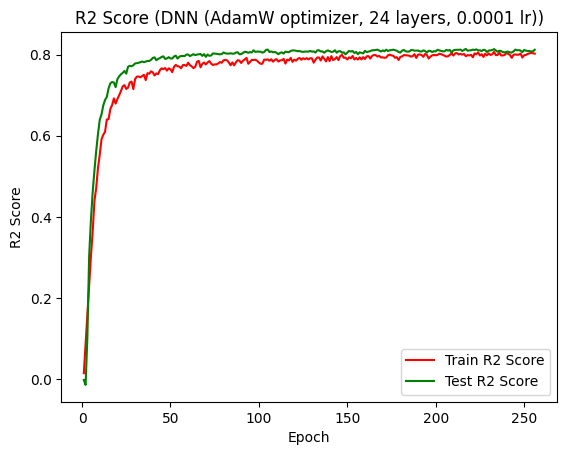

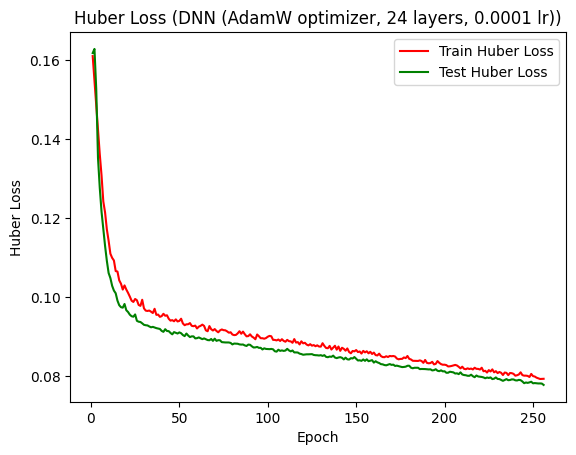

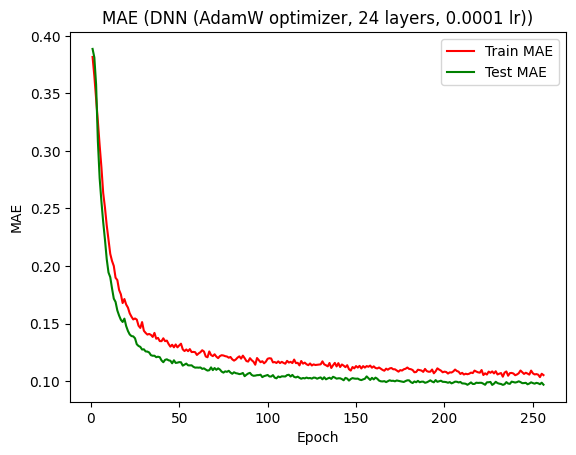

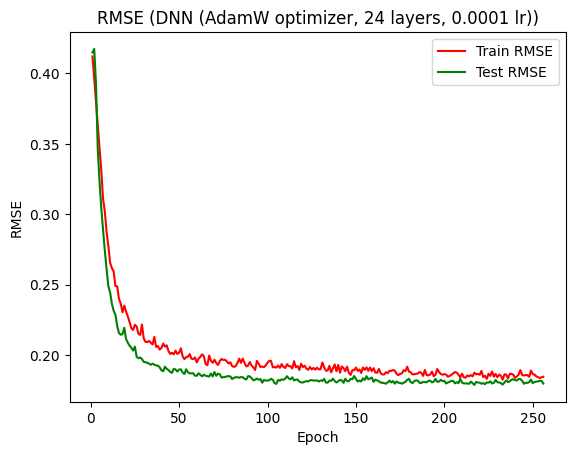

In [234]:
plot_metric_visualize("R2 Score", 
                      training_results['r2_score_train'], 
                      training_results['r2_score_test'], 
                      optimizer.__name__, 
                      n_layers, 
                      lr, 
                      epochs
                      )

plot_metric_visualize("Huber Loss", 
                      training_results['loss_train'], 
                      training_results['loss_test'], 
                      optimizer.__name__, 
                      n_layers, 
                      lr, 
                      epochs
                      )

plot_metric_visualize("MAE", 
                      training_results['mae_train'], 
                      training_results['mae_test'], 
                      optimizer.__name__, 
                      n_layers, 
                      lr, 
                      epochs
                      )

plot_metric_visualize("RMSE", 
                      training_results['rmse_train'], 
                      training_results['rmse_test'], 
                      optimizer.__name__, 
                      n_layers, 
                      lr, 
                      epochs
                      )

In [235]:
print(f"\n Training time: {end_time - start_time}")


 Training time: 178.01377415657043


In [236]:
true_labels = y_test_tensor.cpu().detach().numpy()
predicted_labels = model(x_test_tensor).cpu().detach().numpy()

print(true_labels)
print(predicted_labels)

[[0.15]
 [0.96]
 [0.02]
 ...
 [0.95]
 [0.52]
 [0.48]]
[[0.1277757 ]
 [0.9563427 ]
 [0.03812118]
 ...
 [0.9452466 ]
 [0.5879338 ]
 [0.5752078 ]]


In [237]:
bias_squared = (np.mean(training_results['loss_train']) - np.min(training_results['loss_test'])) ** 2
variance = np.var(training_results['loss_test'])
print(f"Bias^2: {bias_squared}")
print(f"Variance: {variance}")

Bias^2: 0.00015009668908028617
Variance: 0.00011978721687236501


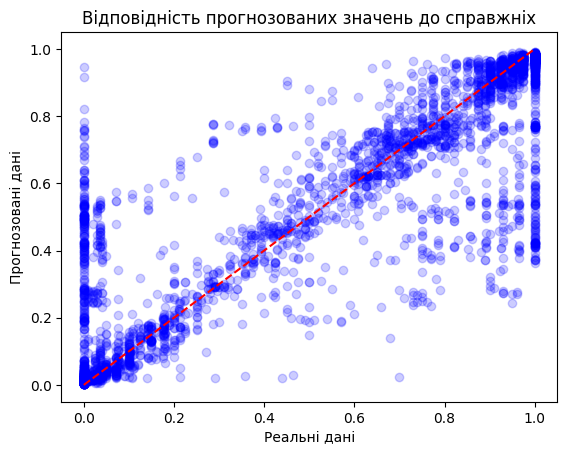

In [238]:
def scatter_plot_actual_vs_predicted(actual, predicted):
    plt.scatter(actual, predicted, color='blue', alpha=0.2)
    plt.plot([min(actual), max(actual)], [min(actual), max(actual)], color='red', linestyle='--')
    plt.xlabel('Реальні дані')
    plt.ylabel('Прогнозовані дані')
    plt.title('Відповідність прогнозованих значень до справжніх')
    plt.show()

scatter_plot_actual_vs_predicted(true_labels, predicted_labels)